In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [1]:
import os
import datetime

import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard

import seaborn as sns
import matplotlib.pyplot as plt

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'
NO_EPOCHS = 10

In [4]:
train_validation_img_generator = ImageDataGenerator(validation_split=0.1, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_partial_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

train_validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

Found 2061 images belonging to 2 classes.
Found 228 images belonging to 2 classes.


In [5]:
def define_model_architecture_32():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def define_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
class SkipLoggerCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, n):
        self.n = n
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            val_loss = logs.get('val_loss')
            val_accuracy = logs.get('val_accuracy')
            print("epoch = %4d    loss = %0.6f    accuracy = %0.2f    val_loss = %0.6f    val_accuracy = %0.2f" % (epoch, loss, accuracy, val_loss, val_accuracy))

In [7]:
!rm -rf ./logs/
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
chkpt_dir = 'logs/chkpt' 
os.makedirs(chkpt_dir, exist_ok=True)
chk_callback = ModelCheckpoint(filepath=os.path.join(chkpt_dir, 'weights{epoch:03d}.hdf5'))

In [9]:
model = define_model_architecture_32()
history = model.fit_generator(generator = train_partial_batches, steps_per_epoch=train_partial_batches.samples/BATCH_SIZE, 
                              validation_data = train_validation_batches, validation_steps = train_validation_batches.samples/BATCH_SIZE, 
                              epochs=NO_EPOCHS, verbose=2, workers=4, callbacks = [tb_callback,chk_callback])

Epoch 1/10


W0818 18:28:45.987214 139701019739968 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


65/64 - 6s - loss: 0.6886 - accuracy: 0.5987 - val_loss: 0.7129 - val_accuracy: 0.5614
Epoch 2/10
65/64 - 6s - loss: 0.6333 - accuracy: 0.6448 - val_loss: 0.6690 - val_accuracy: 0.6711
Epoch 3/10
65/64 - 6s - loss: 0.6054 - accuracy: 0.6735 - val_loss: 0.6830 - val_accuracy: 0.6096
Epoch 4/10
65/64 - 6s - loss: 0.5968 - accuracy: 0.6807 - val_loss: 0.6782 - val_accuracy: 0.6886
Epoch 5/10
65/64 - 6s - loss: 0.5954 - accuracy: 0.6812 - val_loss: 0.6305 - val_accuracy: 0.6798
Epoch 6/10
65/64 - 6s - loss: 0.5980 - accuracy: 0.6783 - val_loss: 0.7174 - val_accuracy: 0.6272
Epoch 7/10
65/64 - 6s - loss: 0.5914 - accuracy: 0.6836 - val_loss: 0.6208 - val_accuracy: 0.6974
Epoch 8/10
65/64 - 6s - loss: 0.5849 - accuracy: 0.6914 - val_loss: 0.6271 - val_accuracy: 0.6623
Epoch 9/10
65/64 - 6s - loss: 0.5859 - accuracy: 0.6934 - val_loss: 0.6337 - val_accuracy: 0.7061
Epoch 10/10
65/64 - 6s - loss: 0.5792 - accuracy: 0.6832 - val_loss: 0.5843 - val_accuracy: 0.7105


In [10]:
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

In [11]:
for cnt,layer in enumerate(model.layers):
    if "dense" in layer.name:
        print('Layer : %d - %s'% (cnt, layer.name))
        print('Layer weight shape : %s' % str(layer.get_weights()[0].shape))
        print('Layer bias shape : %s' % str(layer.get_weights()[1].shape))

Layer : 1 - dense
Layer weight shape : (784, 32)
Layer bias shape : (32,)
Layer : 2 - dense_1
Layer weight shape : (32, 2)
Layer bias shape : (2,)


In [12]:
def get_model_weigths(model):
    model_weights_dict = {}
    for cnt,layer in enumerate(model.layers):
        if "dense" in layer.name:
            model_weights_dict[layer.name + '_weights'] = layer.get_weights()[0]
            model_weights_dict[layer.name + '_bias'] = layer.get_weights()[1]
    return model_weights_dict

In [13]:
model_tmp = define_model_architecture_32()
weight_history = []
for epoch in range(NO_EPOCHS):
    model_chkpt_path = os.path.join(chkpt_dir,"weights{:03d}.hdf5".format(epoch+1))
    model_tmp.load_weights(model_chkpt_path)
    model_weights_dict = get_model_weigths(model_tmp)
    weight_history.append(model_weights_dict)

In [14]:
model_weights_dict.keys()

dict_keys(['dense_2_weights', 'dense_2_bias', 'dense_3_weights', 'dense_3_bias'])

In [16]:
matrix_name = 'dense_2_weights'
neuron_index = 12
neuron_history = []
for epoch in range(NO_EPOCHS):
    neuron_mat = weight_history[epoch][matrix_name]
    if neuron_mat.ndim > 1 :
        neuron_mat = weight_history[epoch][matrix_name][:,neuron_index]
    else:
        neuron_mat = weight_history[epoch][matrix_name][neuron_index]
    neuron_history.append(neuron_mat)

In [17]:
neuron_history_data = pd.DataFrame(neuron_history).transpose()

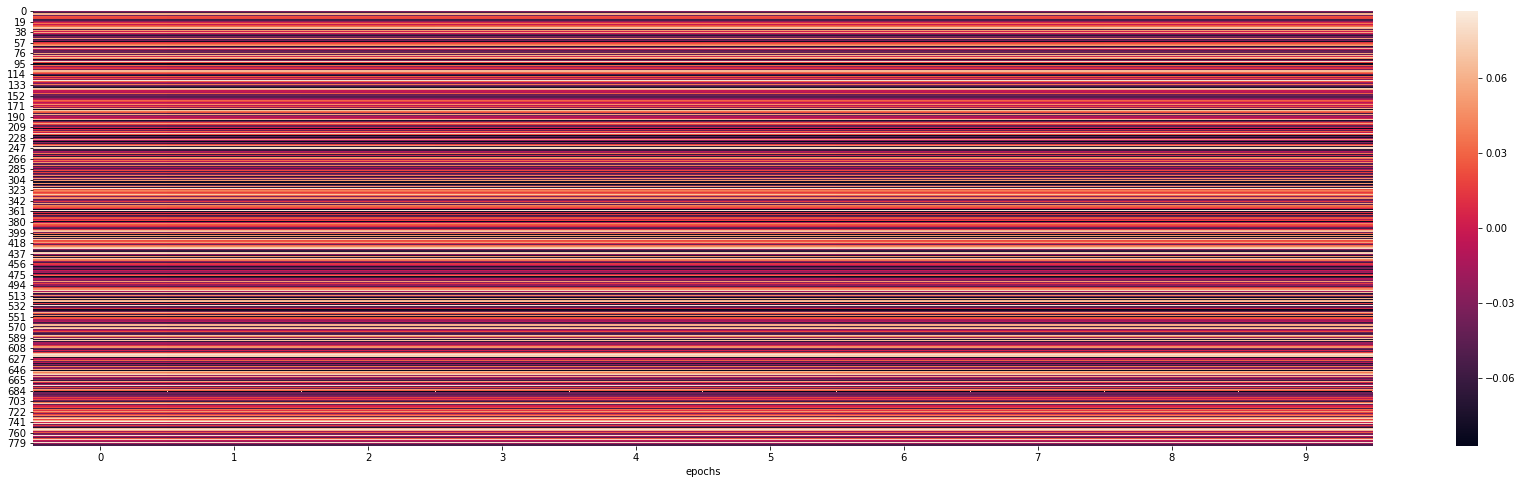

In [18]:
plt.figure(figsize=(30,8))
sns.heatmap(neuron_history_data)
plt.xlabel('epochs')
plt.show()

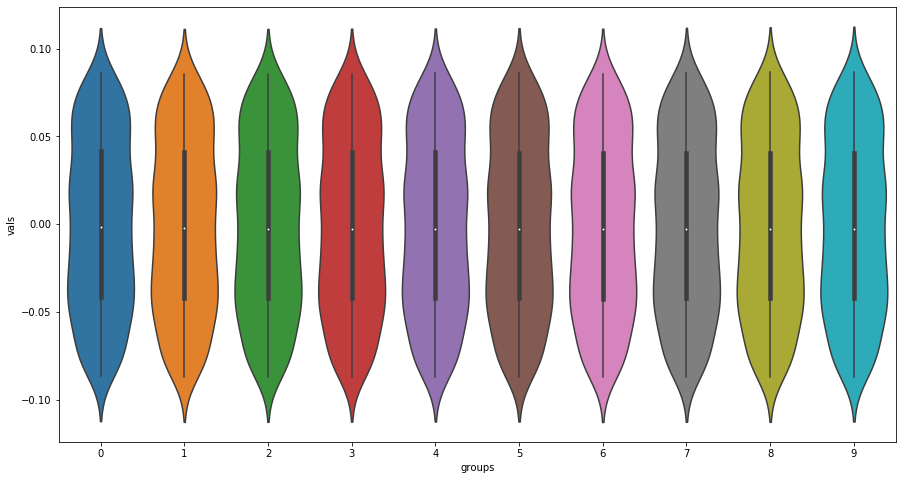

In [19]:
tmp_vis_data = neuron_history_data.melt(var_name='groups', value_name='vals')


plt.figure(figsize=(15,8))
sns.violinplot(x="groups", y="vals", data=tmp_vis_data)

### Full 500 epoch training weight visualization

In [99]:
NO_EPOCHS = 300
SAVE_FREQ = 50

!rm -rf ./logs/
chkpt_dir = 'logs/chkpt' 
os.makedirs(chkpt_dir, exist_ok=True)
chk_callback = ModelCheckpoint(filepath=os.path.join(chkpt_dir, 'weights{epoch:03d}.hdf5'), period=SAVE_FREQ)

W0818 22:31:07.398511 139701019739968 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [100]:
skipLogger_callback = SkipLoggerCallback(n=25)

In [101]:
model = define_model_architecture_32()
model.save(os.path.join(chkpt_dir, 'weights000.hdf5'))
history = model.fit_generator(generator = train_partial_batches, steps_per_epoch=train_partial_batches.samples/BATCH_SIZE, 
                              validation_data = train_validation_batches, validation_steps = train_validation_batches.samples/BATCH_SIZE, 
                              epochs=NO_EPOCHS, verbose=0, workers=4, callbacks = [tb_callback,chk_callback,skipLogger_callback])

epoch =    0    loss = 0.670392    accuracy = 0.59    val_loss = 0.711651    val_accuracy = 0.62
epoch =   25    loss = 0.538458    accuracy = 0.74    val_loss = 0.595862    val_accuracy = 0.74
epoch =   50    loss = 0.502280    accuracy = 0.77    val_loss = 0.605541    val_accuracy = 0.74
epoch =   75    loss = 0.488444    accuracy = 0.78    val_loss = 0.484253    val_accuracy = 0.80
epoch =  100    loss = 0.479549    accuracy = 0.78    val_loss = 0.443533    val_accuracy = 0.83
epoch =  125    loss = 0.467491    accuracy = 0.79    val_loss = 0.532841    val_accuracy = 0.79
epoch =  150    loss = 0.468106    accuracy = 0.79    val_loss = 0.556569    val_accuracy = 0.79
epoch =  175    loss = 0.464438    accuracy = 0.79    val_loss = 0.658743    val_accuracy = 0.75
epoch =  200    loss = 0.444626    accuracy = 0.81    val_loss = 0.574209    val_accuracy = 0.81
epoch =  225    loss = 0.436622    accuracy = 0.80    val_loss = 0.547541    val_accuracy = 0.80
epoch =  250    loss = 0.42938

In [102]:
!ls -l logs/chkpt/

total 812
-rw-r--r-- 1 algolaptop8 algolaptop8 115752 Aug 18 22:31 weights000.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:35 weights050.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:40 weights100.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:45 weights150.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:50 weights200.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:54 weights250.hdf5
-rw-r--r-- 1 algolaptop8 algolaptop8 118176 Aug 18 22:59 weights300.hdf5


In [105]:
model_tmp = define_model_architecture_32()
weight_history = []
for epoch in range(0,NO_EPOCHS+1,SAVE_FREQ):
    model_chkpt_path = os.path.join(chkpt_dir,"weights{:03d}.hdf5".format(epoch))
    model_tmp.load_weights(model_chkpt_path)
    model_weights_dict = get_model_weigths(model_tmp)
    weight_history.append(model_weights_dict)

In [106]:
model_weights_dict.keys()

dict_keys(['dense_22_weights', 'dense_22_bias', 'dense_23_weights', 'dense_23_bias'])

In [109]:
matrix_name = 'dense_22_weights'
neuron_index = 12
neuron_history = []
epoch_nos_list = [epoch for epoch in range(0,NO_EPOCHS+1,SAVE_FREQ)]
for epoch_ix, epoch in enumerate(epoch_nos_list):
    neuron_mat = weight_history[epoch_ix][matrix_name]
    if neuron_mat.ndim > 1 :
        neuron_mat = weight_history[epoch_ix][matrix_name][:,neuron_index]
    else:
        neuron_mat = weight_history[epoch_ix][matrix_name][neuron_index]
    neuron_history.append(neuron_mat)

In [110]:
neuron_history_data = pd.DataFrame(neuron_history).transpose()

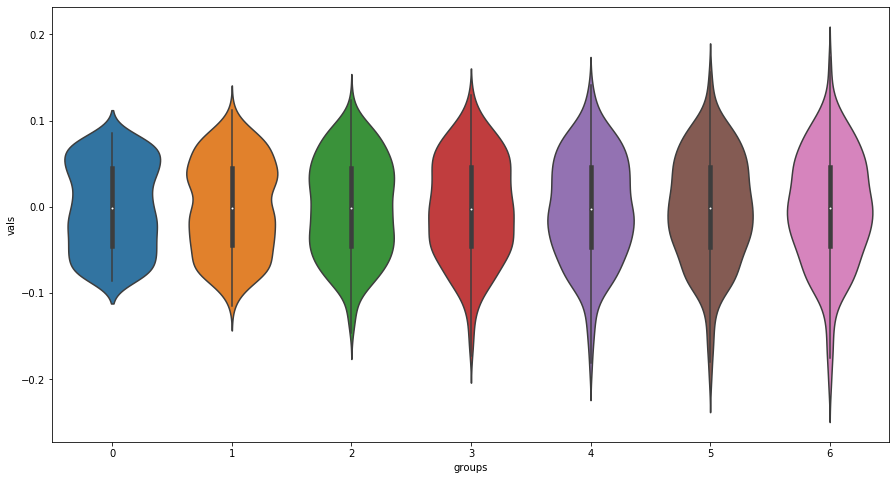

In [111]:
tmp_vis_data = neuron_history_data.melt(var_name='groups', value_name='vals')

plt.figure(figsize=(15,8))
sns.violinplot(x="groups", y="vals", data=tmp_vis_data)

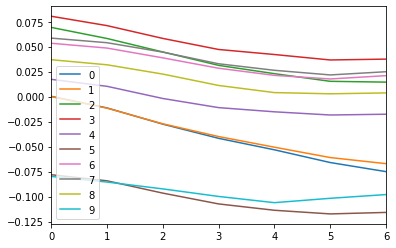

In [112]:
neuron_history_data[:10].transpose().plot()

In [145]:
matrix_name = 'dense_22_weights'
layer_history = []
epoch_nos_list = [epoch for epoch in range(0,NO_EPOCHS+1,SAVE_FREQ)]
for epoch_ix, epoch in enumerate(epoch_nos_list):
    neuron_mat = weight_history[epoch_ix][matrix_name]
    layer_history.append(neuron_mat.flatten())

In [148]:
layer_data = pd.DataFrame(layer_history).transpose()

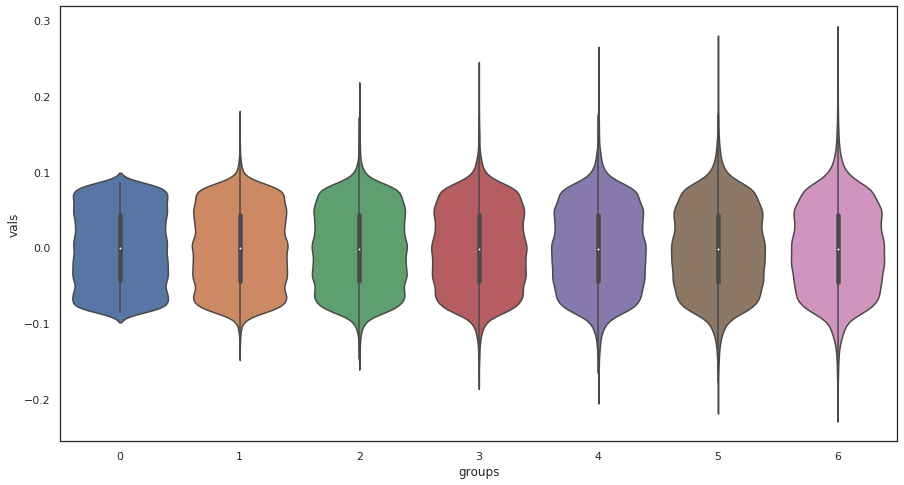

In [149]:
tmp_vis_data = layer_data.melt(var_name='groups', value_name='vals')

plt.figure(figsize=(15,8))
sns.violinplot(x="groups", y="vals", data=tmp_vis_data)

In [150]:
!rm -rf ./logs/